# Translation model from COCO -> MPII


In [34]:
import torch
import numpy as np
import torch.nn as nn
import copy
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import json

In [35]:
def describe(data):
  # Find maximum value
  max_val = np.max(data)

  # Find minimum value
  min_val = np.min(data)

  # Find 25th percentile
  percentile_25 = np.percentile(data, 25)

  # Find 75th percentile
  percentile_75 = np.percentile(data, 75)

  print("Maximum:", max_val)
  print("Minimum:", min_val)
  print("25th percentile:", percentile_25)
  print("75th percentile:", percentile_75)

In [36]:


ROOT_FOLDER = "/datagrid/personal/baljibil"
# ground truth
with open(ROOT_FOLDER + '/repos/scripts/data/mpii_train_gt.json', 'r') as f:
    annot_truth = json.load(f)
# prediction
with open(ROOT_FOLDER + '/repos/scripts/data/coco_pred_mpii.json', 'r') as f:
    annot_pred_coco = json.load(f)

# with open(ROOT_FOLDER + '/repos/scripts/mpii_pred_on_mpii/pred.json', 'r') as f:
#     annot_pred_mpii = json.load(f)



In [37]:
X = list()
y = list()
box_scale = list()
box_center = list()
for i in range(len(annot_truth)):
  skip = False
  for joint_vis in annot_truth[i]['joints_vis']:
    if joint_vis == 0:
      skip = True
      break
  if skip:
    continue
  X.append(annot_pred_coco['annotations'][i]['joints'])
  y.append(annot_truth[i]['joints'])
  box_scale.append(annot_truth[i]['scale'])
  box_center.append(annot_truth[i]['center'])
X = np.array(X)
y = np.array(y)
box_scale = np.array(box_scale)
box_center = np.array(box_center)
print("X shape: ", X.shape)
print("y shape:", y.shape)
print("box scale:", box_scale.shape)
print("box center:", box_center.shape)

X shape:  (14975, 17, 2)
y shape: (14975, 16, 2)
box scale: (14975,)
box center: (14975, 2)


## Normalize the dataset
- First by scale value of the bounding box
- Then either 0-1 normalization

In [38]:

X_normalized = X - np.repeat(box_center[:, np.newaxis, :], 17, axis=1)
X_normalized = X_normalized / box_scale[:, np.newaxis, np.newaxis]
y_normalized = y - np.repeat(box_center[:, np.newaxis, :], 16, axis=1)
y_normalized = y_normalized / box_scale[:, np.newaxis, np.newaxis]
describe(X_normalized)
describe(y_normalized)
print(X_normalized)
# print(_normalized)
# Remove outliers, probably joint_vis = 0


Maximum: 142.49721067436224
Minimum: -127.8703812075263
25th percentile: -29.486130751675454
75th percentile: 18.7032727790721
Maximum: 182.44418701336446
Minimum: -414.840529399002
25th percentile: -23.56968379968597
75th percentile: 19.339848243111714
[[[ 26.69395857 -24.81517112]
  [ 27.18255564 -27.81869754]
  [ 26.2485966  -28.02612502]
  ...
  [  7.6544517    6.65665018]
  [ 26.89122378  16.3632136 ]
  [  9.93702269  44.7087733 ]]

 [[-33.97625846  -3.82092363]
  [-35.06056879  -7.04447419]
  [-34.68983233  -7.03965975]
  ...
  [-17.23490007  26.49794163]
  [  2.70304803  74.79883375]
  [  0.63195062  50.46456255]]

 [[ 11.50092068 -38.81746106]
  [ 10.47930103 -42.10066133]
  [ 10.76991439 -41.94341554]
  ...
  [  6.8358103   10.53491068]
  [ 11.99555751  38.59534113]
  [  1.64091725  46.82144966]]

 ...

 [[-49.57831822 -59.18822135]
  [-48.58080192 -63.2677884 ]
  [-48.56012879 -63.44203875]
  ...
  [ 31.85058011  42.43794887]
  [  1.34382897  86.91286135]
  [ 58.93026934  89.

In [39]:
from sklearn.model_selection import train_test_split

## Split train, val, test

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print("Train instance: ", X_train.shape[0])
print("Val instance: ", X_val.shape[0])
print("Test instance: ", X_test.shape[0])

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

Train instance:  7861
Val instance:  2621
Test instance:  4493
torch.Size([7861, 17, 2])
torch.Size([7861, 16, 2])
torch.Size([2621, 17, 2])
torch.Size([2621, 16, 2])


In [41]:
# Create a DataLoader for training and validation data
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset)

In [58]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class TranslatorNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.hidden1 = nn.Linear(17 * 2, 64)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(64, 64)
        self.act2 = nn.ReLU()
        self.hidden5 = nn.Linear(64, 32)
        self.act5 = nn.ReLU()
        self.output = nn.Linear(32, 16*2)
        # self.act_output = nn.Sigmoid()

    def forward(self, x):
        x = self.flatten(x)
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act5(self.hidden5(x))
        x = self.output(x)
        return x.view(-1, 16, 2)

    
# Instantiate the model, loss function, and optimizer
model = TranslatorNN().to(device)
# print(X_train.shape)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 200
best_model = None
best_val_loss = 10000000
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset)
    
    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    val_epoch_loss = val_loss / len(val_dataset)
    if val_loss < best_val_loss:
        best_model = copy.deepcopy(model)
        best_val_loss = val_loss
    if (epoch+1) % 10 == 1:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}")
print(model)



Epoch [1/200], Train Loss: 614.2421, Val Loss: 251.0395
Epoch [11/200], Train Loss: 105.8405, Val Loss: 108.4277
Epoch [21/200], Train Loss: 94.7669, Val Loss: 97.4612
Epoch [31/200], Train Loss: 87.6305, Val Loss: 94.6480
Epoch [41/200], Train Loss: 82.7098, Val Loss: 92.3330
Epoch [51/200], Train Loss: 80.4131, Val Loss: 94.1928
Epoch [61/200], Train Loss: 77.7201, Val Loss: 93.8661
Epoch [71/200], Train Loss: 76.6682, Val Loss: 94.4362
Epoch [81/200], Train Loss: 74.7454, Val Loss: 91.9865
Epoch [91/200], Train Loss: 72.7210, Val Loss: 94.7656
Epoch [101/200], Train Loss: 71.7926, Val Loss: 96.6965
Epoch [111/200], Train Loss: 70.2504, Val Loss: 94.3341
Epoch [121/200], Train Loss: 68.9799, Val Loss: 94.3597
Epoch [131/200], Train Loss: 68.7764, Val Loss: 95.1877
Epoch [141/200], Train Loss: 67.6629, Val Loss: 94.6759
Epoch [151/200], Train Loss: 67.5869, Val Loss: 96.5378
Epoch [161/200], Train Loss: 66.1935, Val Loss: 96.7605
Epoch [171/200], Train Loss: 66.0091, Val Loss: 95.9057

## Display some images from translation model

In [47]:
import cv2
from IPython.display import Image, display

13853 005473964.jpg
torch.Size([1, 17, 2])
keypoints:  torch.Size([1, 16, 2])
[[ -5909.144    -10934.096   ]
 [  5889.08       4844.76    ]
 [  4259.1235     1946.4652  ]
 [  4363.1997     1931.4805  ]
 [  6510.3433     5818.699   ]
 [ -5331.8066    -9105.756   ]
 [  4279.2847     1995.2715  ]
 [  1936.598        16.78675 ]
 [  1947.9576    -1193.3236  ]
 [   606.3682    -2178.5657  ]
 [   324.47623    2534.632   ]
 [  1849.8024      966.4505  ]
 [  1658.0826      -25.467272]
 [  2215.5706      -15.261144]
 [  1831.8232      679.2438  ]
 [  1742.8229     2666.7156  ]]
[[ -4684.14404297 -10340.09570312]
 [  7114.08007812   5438.75976562]
 [  5484.12353516   2540.46520996]
 [  5588.19970703   2525.48046875]
 [  7735.34326172   6412.69921875]
 [ -4106.80664062  -8511.75585938]
 [  5504.28466797   2589.27148438]
 [  3161.59802246    610.78675079]
 [  3172.9576416    -599.3236084 ]
 [  1831.3682251   -1584.56567383]
 [  1549.47622681   3128.63208008]
 [  3074.80236816   1560.45050049]
 [  2

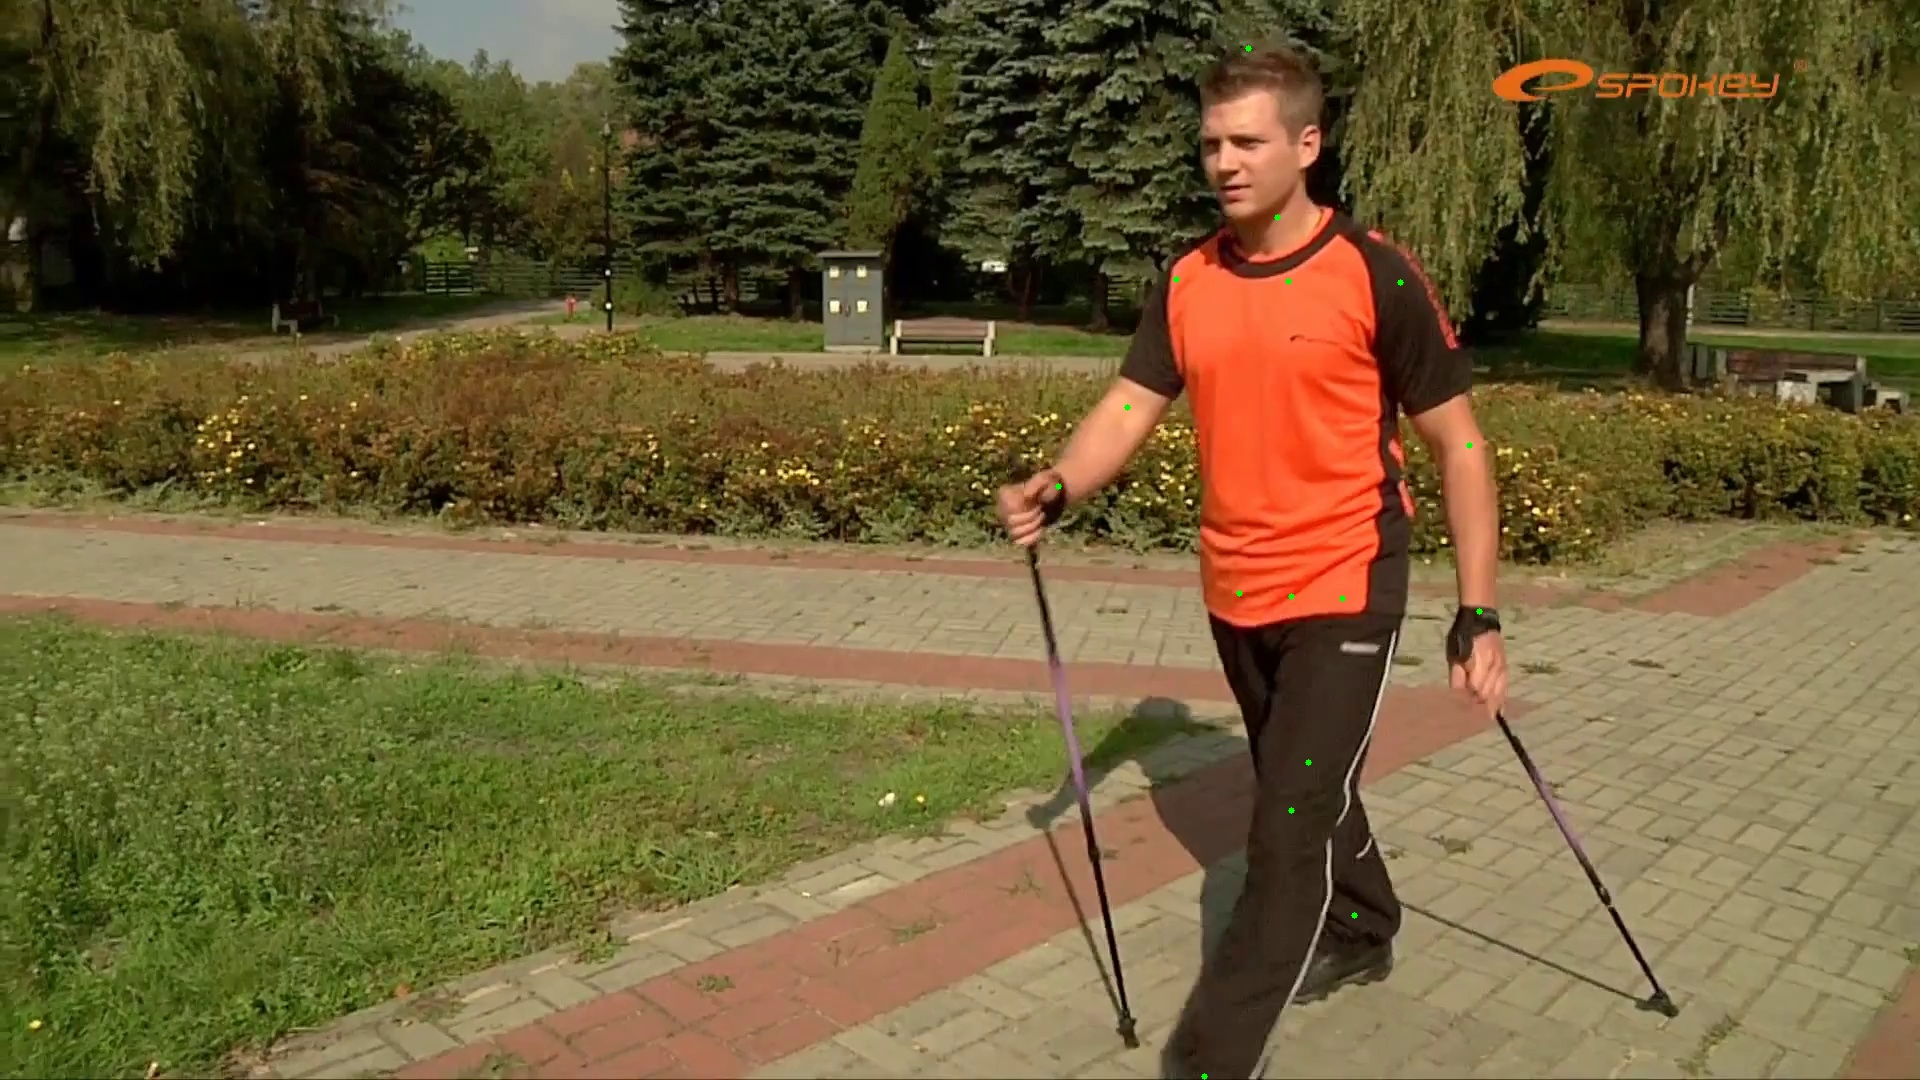

4081 032040129.jpg
torch.Size([1, 17, 2])
keypoints:  torch.Size([1, 16, 2])
[[-1207.2516  -2825.0774 ]
 [ 1484.2919    840.6486 ]
 [ 1228.184     514.45807]
 [ 1301.087     553.262  ]
 [ 1712.6902   1173.8939 ]
 [ -876.7315  -2657.1887 ]
 [ 1246.943     563.0345 ]
 [  481.13397   246.37674]
 [  482.1553    -77.12929]
 [   93.55977  -373.244  ]
 [  153.49394   946.03253]
 [  496.2541    352.1159 ]
 [  466.0967    175.56693]
 [  484.0693    298.18845]
 [  277.03546   381.95496]
 [  328.10208  1026.7334 ]]
[[ -385.25158691 -2338.07739258]
 [ 2306.29187012  1327.64862061]
 [ 2050.18395996  1001.45806885]
 [ 2123.08703613  1040.26202393]
 [ 2534.69018555  1660.8939209 ]
 [  -54.73150635 -2170.1887207 ]
 [ 2068.94299316  1050.03448486]
 [ 1303.13397217   733.3767395 ]
 [ 1304.15530396   409.87071228]
 [  915.55976868   113.75601196]
 [  975.49394226  1433.03253174]
 [ 1318.25408936   839.11590576]
 [ 1288.09671021   662.56692505]
 [ 1306.06930542   785.18844604]
 [ 1099.03546143   868.95495

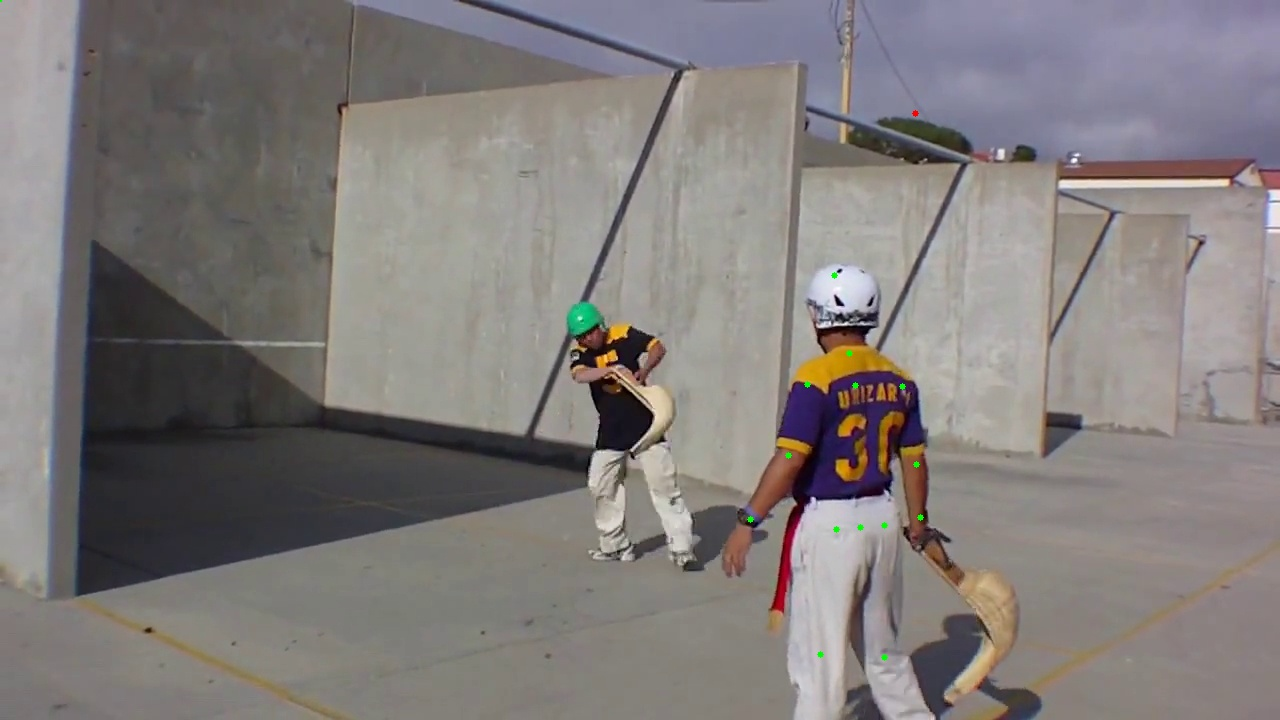

254 074076862.jpg
torch.Size([1, 17, 2])
keypoints:  torch.Size([1, 16, 2])
[[-2635.8577   -3004.0396  ]
 [  602.70337   1148.5452  ]
 [  639.8673     617.02515 ]
 [  824.6139     633.91486 ]
 [  909.8397    1195.5674  ]
 [-2226.6677   -2989.254   ]
 [  708.3281     644.9749  ]
 [  472.22305    254.41806 ]
 [  500.09393     45.424095]
 [  342.96765   -182.90515 ]
 [  204.40155   1032.6042  ]
 [  524.0635     521.446   ]
 [  445.51257    238.89223 ]
 [  510.20233    262.47452 ]
 [  473.85504    407.43716 ]
 [  634.06244    821.9063  ]]
[[-2244.85766602 -2760.03955078]
 [  993.70336914  1392.54516602]
 [ 1030.86730957   861.02514648]
 [ 1215.6138916    877.91485596]
 [ 1300.83972168  1439.56738281]
 [-1835.66772461 -2745.25390625]
 [ 1099.328125     888.97491455]
 [  863.22305298   498.4180603 ]
 [  891.09393311   289.42409515]
 [  733.96765137    61.09484863]
 [  595.40155029  1276.60424805]
 [  915.06347656   765.44598389]
 [  836.51257324   482.89222717]
 [  901.20233154   506.4745178

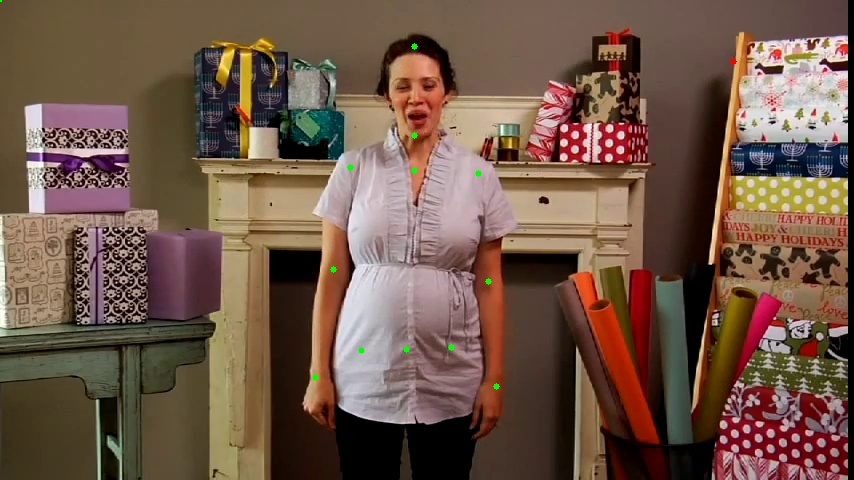

9110 034442805.jpg
torch.Size([1, 17, 2])
keypoints:  torch.Size([1, 16, 2])
[[ -766.5594   -1199.3239  ]
 [  394.1147     360.28333 ]
 [  352.09937    226.31058 ]
 [  375.38428    240.22444 ]
 [  456.74268    378.17355 ]
 [ -625.60266  -1154.8773  ]
 [  364.70328    237.55591 ]
 [  169.0239     146.31482 ]
 [  176.12202     35.812294]
 [   72.783554   -56.792244]
 [   65.5145     370.7664  ]
 [  236.61754    191.69153 ]
 [  193.8787     144.65381 ]
 [  142.59407    137.20508 ]
 [  109.85176    158.15091 ]
 [  154.61865    321.80524 ]]
[[-421.55938721 -930.32385254]
 [ 739.11468506  629.2833252 ]
 [ 697.09936523  495.31057739]
 [ 720.38427734  509.22444153]
 [ 801.74267578  647.17355347]
 [-280.60266113 -885.87731934]
 [ 709.70327759  506.5559082 ]
 [ 514.02389526  415.31481934]
 [ 521.12202454  304.81229401]
 [ 417.78355408  212.20775604]
 [ 410.51450348  639.76638794]
 [ 581.61753845  460.69152832]
 [ 538.87869263  413.65380859]
 [ 487.59407043  406.20507812]
 [ 454.85176086  427.150

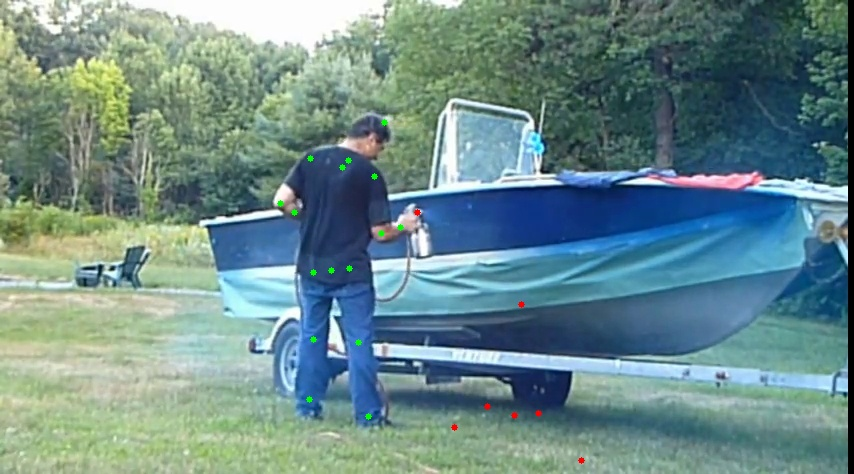

649 056513318.jpg
torch.Size([1, 17, 2])
keypoints:  torch.Size([1, 16, 2])
[[-8.3044098e+02 -1.7479806e+03]
 [ 1.3139635e+03  9.3483887e+02]
 [ 9.0988501e+02  3.2460800e+02]
 [ 9.9033130e+02  3.3408228e+02]
 [ 1.5966049e+03  1.2261713e+03]
 [-5.1064349e+02 -1.4941859e+03]
 [ 9.3209259e+02  3.5280209e+02]
 [ 3.3200143e+02 -4.7126915e+01]
 [ 3.3682700e+02 -3.0494943e+02]
 [ 7.1835236e+01 -5.7372858e+02]
 [ 1.3305684e+02  4.9445465e+02]
 [ 3.0923492e+02  7.6346542e+01]
 [ 2.4896184e+02 -1.0221236e+02]
 [ 4.0746707e+02 -3.3697766e-01]
 [ 2.9237851e+02  8.3237915e+01]
 [ 2.9637274e+02  5.1014459e+02]]
[[  -87.440979   -1418.98059082]
 [ 2056.96350098  1263.83886719]
 [ 1652.88500977   653.60800171]
 [ 1733.33129883   663.08227539]
 [ 2339.6048584   1555.17126465]
 [  232.35650635 -1165.18591309]
 [ 1675.09259033   681.80209351]
 [ 1075.00143433   281.87308502]
 [ 1079.82699585    24.05056763]
 [  814.8352356   -244.72857666]
 [  876.05683899   823.45465088]
 [ 1052.23492432   405.34654236]

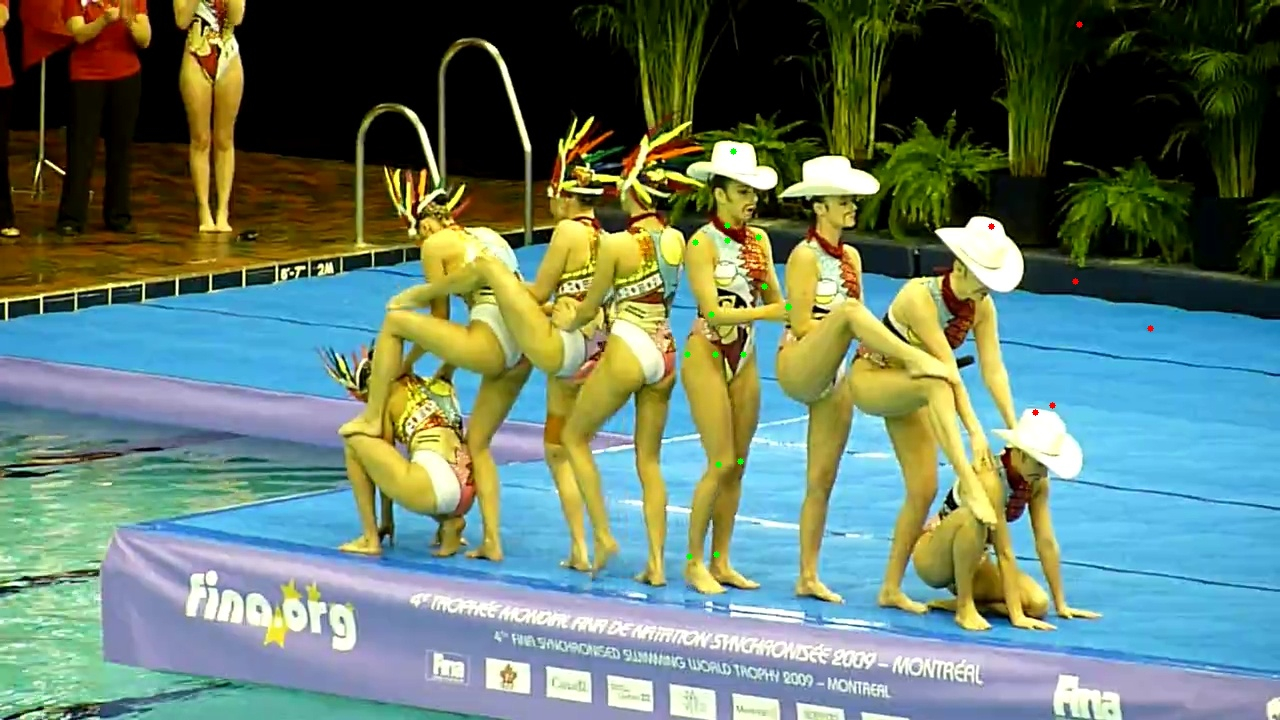

12850 044529477.jpg
torch.Size([1, 17, 2])
keypoints:  torch.Size([1, 16, 2])
[[2649.4966   -152.38452 ]
 [2151.5305   -413.36288 ]
 [1165.2965    277.36392 ]
 [1630.9655    343.0008  ]
 [2395.4077   -312.16147 ]
 [2953.7822   -197.25798 ]
 [1502.0012    258.08163 ]
 [-331.0926    661.346   ]
 [-308.5505    350.88614 ]
 [-913.1546    430.4512  ]
 [-244.49661  1452.1702  ]
 [-224.87668   796.68994 ]
 [-723.15894   648.23615 ]
 [  48.593544  592.56    ]
 [ 548.33295   835.02057 ]
 [ 971.18634  1307.152   ]]
[[3083.49658203  390.61547852]
 [2585.53051758  129.63711548]
 [1599.29650879  820.36392212]
 [2064.9654541   886.00079346]
 [2829.40771484  230.83853149]
 [3387.78222656  345.74201965]
 [1936.0012207   801.08163452]
 [ 102.90740967 1204.3460083 ]
 [ 125.44949341  893.88613892]
 [-479.15460205  973.45120239]
 [ 189.50338745 1995.17016602]
 [ 209.12332153 1339.68994141]
 [-289.15893555 1191.23614502]
 [ 482.59354401 1135.55999756]
 [ 982.33294678 1378.02056885]
 [1405.18634033 1850.151

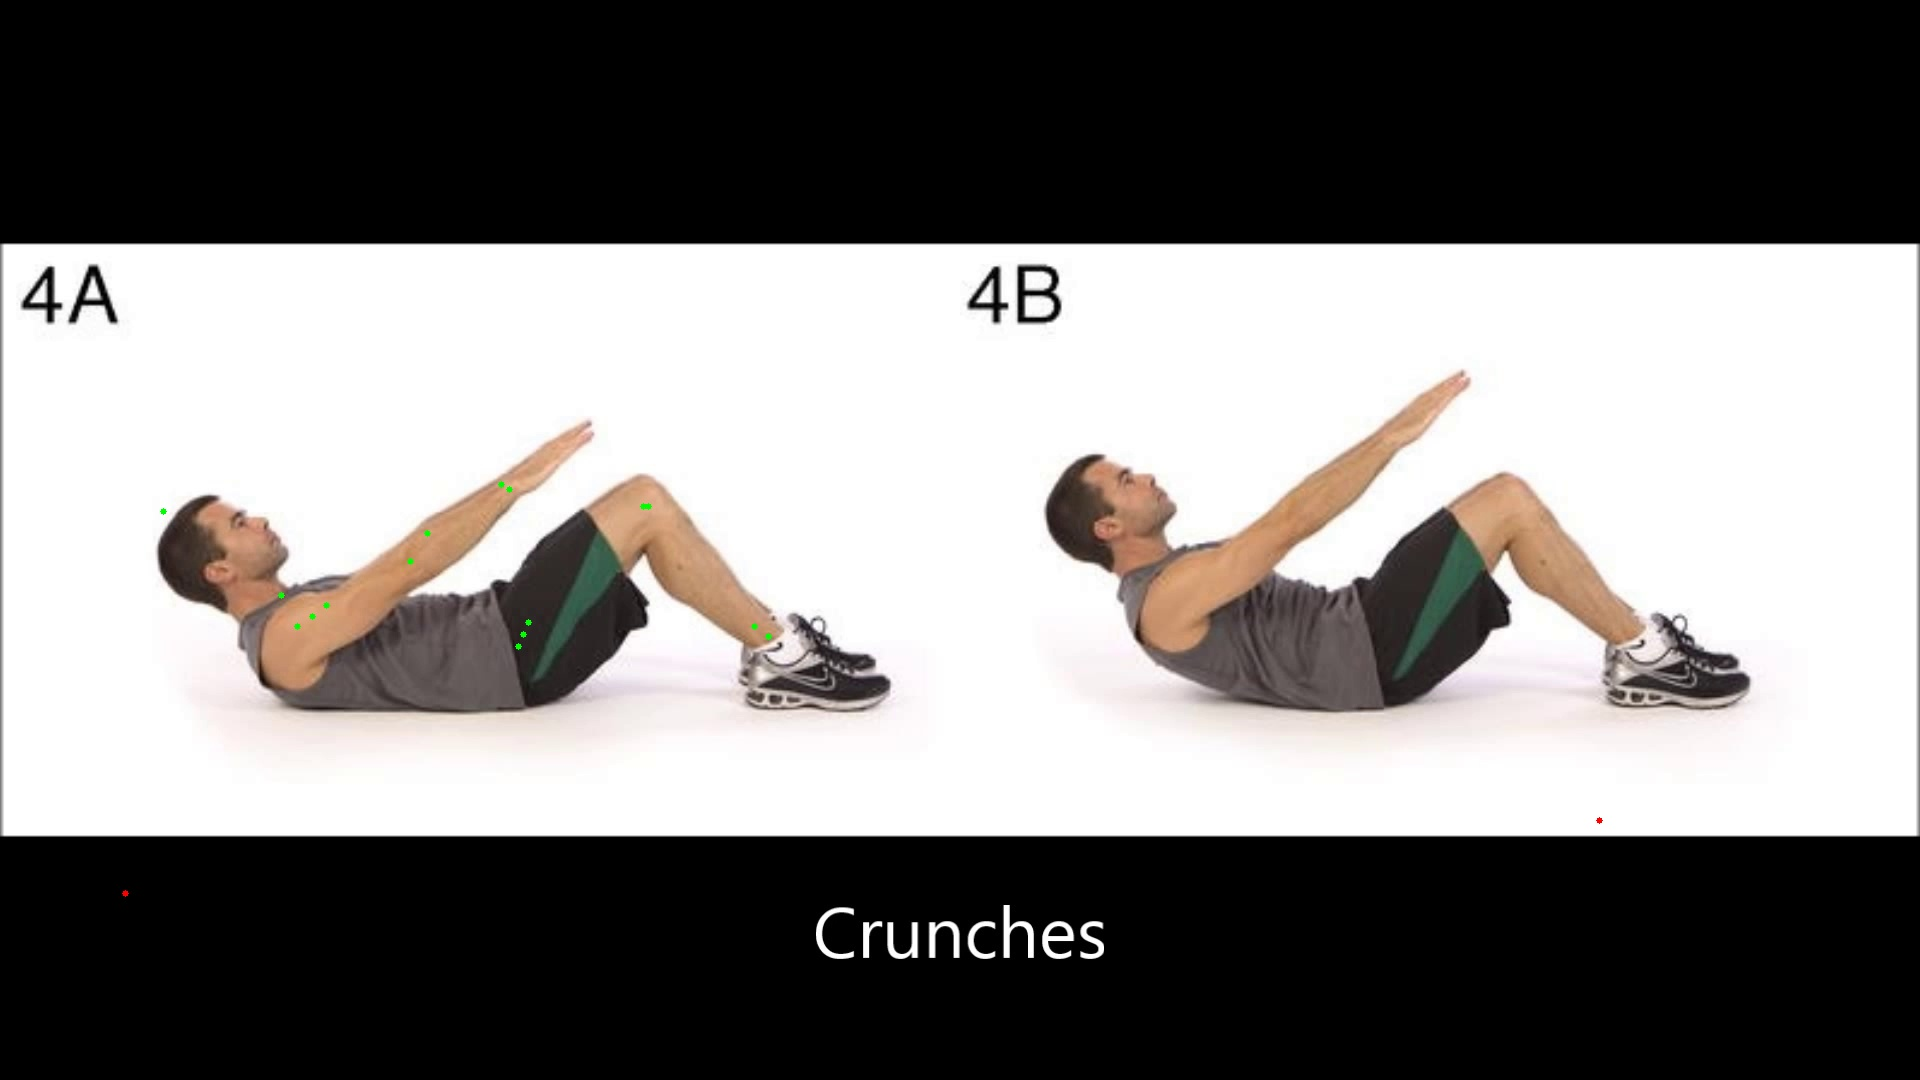

11406 056484917.jpg
torch.Size([1, 17, 2])
keypoints:  torch.Size([1, 16, 2])
[[-2600.9167  -4897.4614 ]
 [ 4698.2495   3647.4336 ]
 [ 3162.0508   1127.8082 ]
 [ 3189.511    1006.30383]
 [ 5569.7007   4288.379  ]
 [-1033.2018  -3572.3506 ]
 [ 3125.022    1131.7955 ]
 [  860.8705   -660.6252 ]
 [  841.7485  -1429.5411 ]
 [ -235.69948 -2259.793  ]
 [   75.188     882.87164]
 [  882.4002   -305.212  ]
 [  650.5258   -789.8036 ]
 [ 1048.6409   -551.1251 ]
 [  589.24786  -416.57733]
 [  493.5161    617.89185]]
[[-1551.91674805 -4528.46142578]
 [ 5747.24951172  4016.43359375]
 [ 4211.05078125  1496.80822754]
 [ 4238.51098633  1375.30383301]
 [ 6618.70068359  4657.37890625]
 [   15.79821777 -3203.35058594]
 [ 4174.02197266  1500.79553223]
 [ 1909.8704834   -291.62518311]
 [ 1890.74847412 -1060.5411377 ]
 [  813.30052185 -1890.79296875]
 [ 1124.18800354  1251.87164307]
 [ 1931.40020752    63.78799438]
 [ 1699.52581787  -420.80358887]
 [ 2097.64086914  -182.12512207]
 [ 1638.24786377   -47.5773

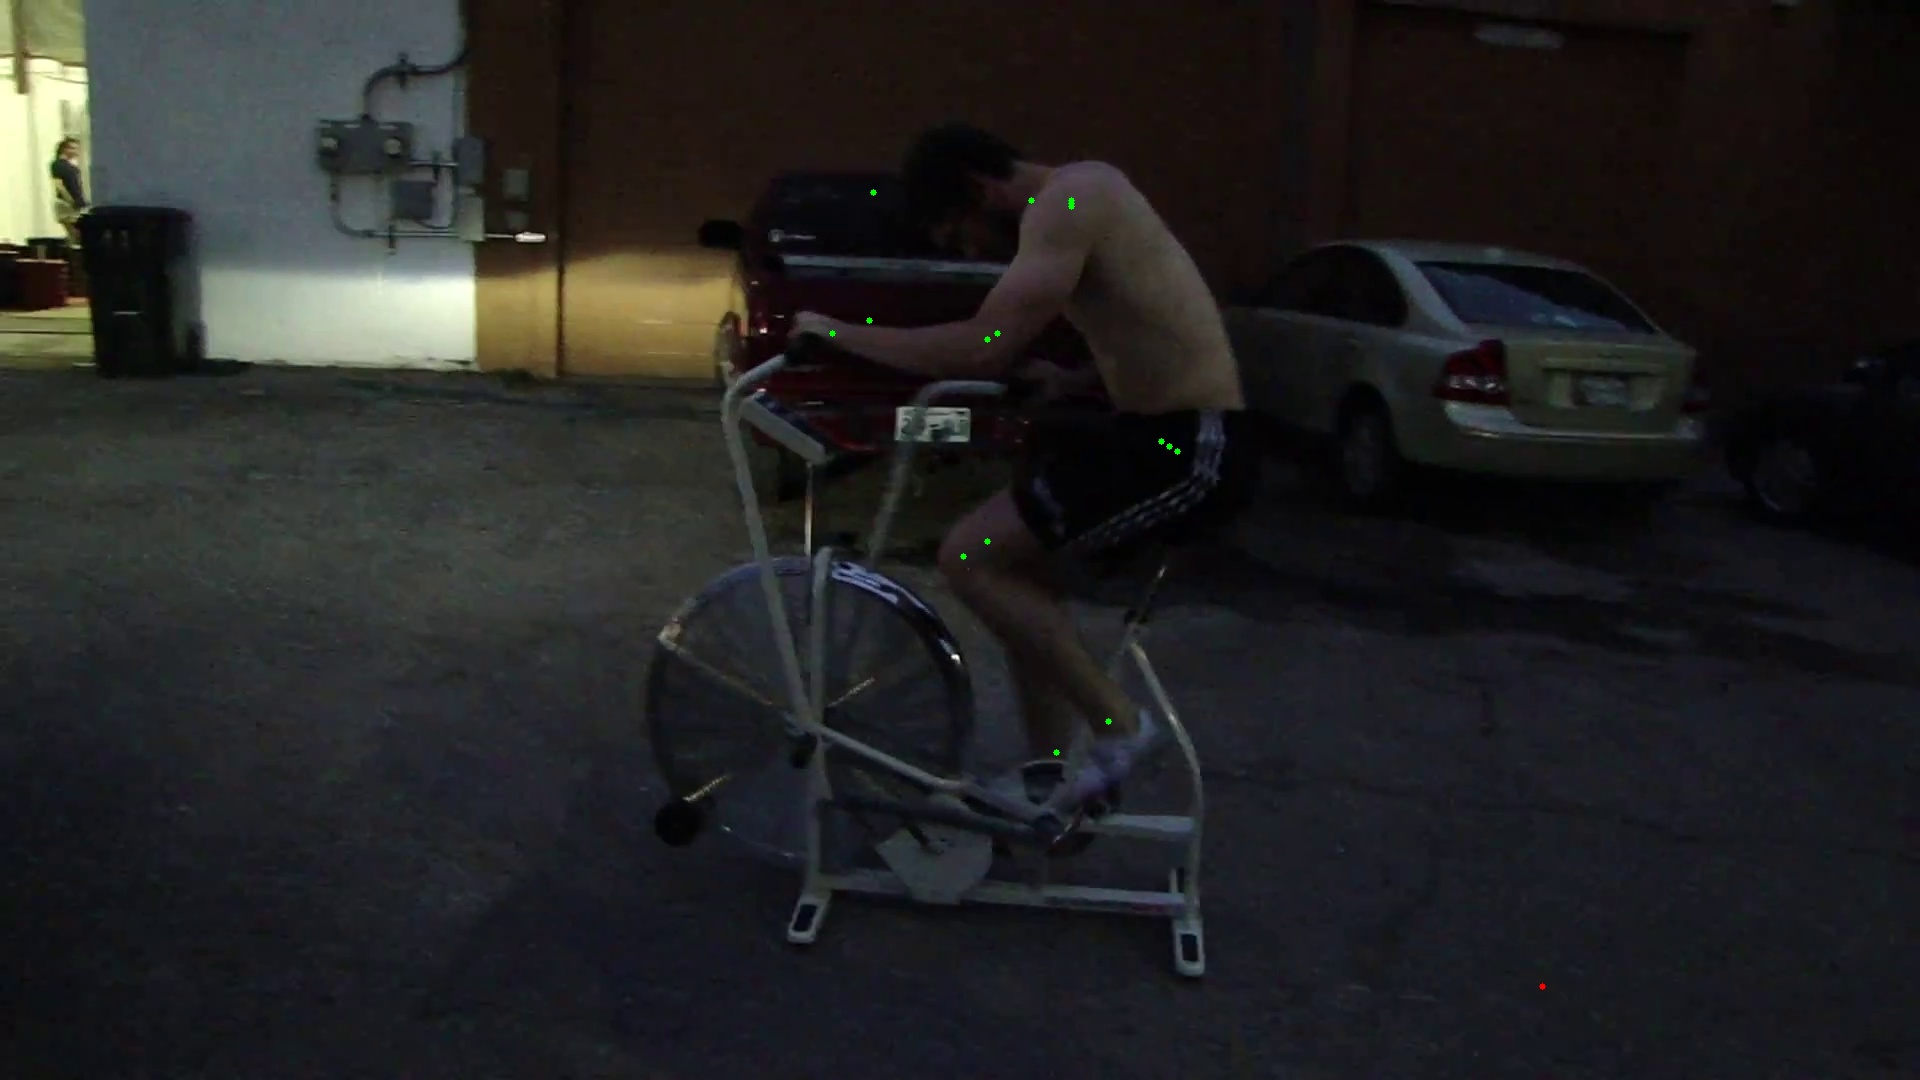

3769 018445905.jpg
torch.Size([1, 17, 2])
keypoints:  torch.Size([1, 16, 2])
[[ -909.9069  -1246.0164 ]
 [  213.52861   296.59625]
 [  278.5061    229.61234]
 [  297.8813    240.28738]
 [  223.56544   241.83983]
 [ -787.06067 -1253.4158 ]
 [  287.88702   238.43405]
 [  212.64742   193.27696]
 [  222.68132   109.46304]
 [  164.97287    50.94869]
 [   98.39651   434.63364]
 [  278.38028   265.48325]
 [  248.8972    193.35947]
 [  177.166     184.71689]
 [  133.69609   228.70782]
 [  206.2786    356.16644]]
[[-650.90692139 -962.01635742]
 [ 472.52861023  580.59625244]
 [ 537.50610352  513.61233521]
 [ 556.88128662  524.28738403]
 [ 482.56544495  525.83982849]
 [-528.06066895 -969.41577148]
 [ 546.88702393  522.43405151]
 [ 471.64741516  477.27696228]
 [ 481.68132019  393.46304321]
 [ 423.97286987  334.94868851]
 [ 357.39650726  718.63363647]
 [ 537.38027954  549.48324585]
 [ 507.89720154  477.35946655]
 [ 436.16600037  468.71688843]
 [ 392.6960907   512.70782471]
 [ 465.27859497  640.1664

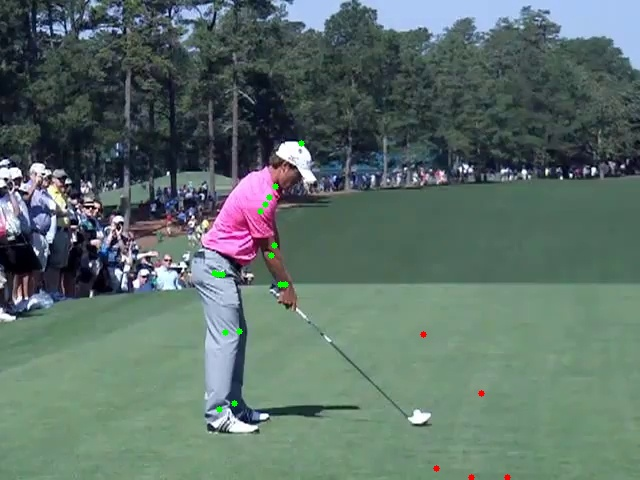

19714 010669007.jpg
torch.Size([1, 17, 2])
keypoints:  torch.Size([1, 16, 2])
[[-2208.798    -2489.5098  ]
 [ -758.7974      60.121548]
 [  717.2912     957.23816 ]
 [  433.39084    837.1231  ]
 [-1173.7372    -354.5057  ]
 [-2443.9697   -2751.9058  ]
 [  506.9297     930.5446  ]
 [  636.89343    457.16226 ]
 [  697.4084     467.30743 ]
 [  830.98016    233.76428 ]
 [  991.4762    1126.7749  ]
 [  855.39966    937.6571  ]
 [  894.8676     415.55936 ]
 [  402.77258    545.4901  ]
 [  491.06766    946.4937  ]
 [  660.314     1043.4177  ]]
[[-2160.7980957  -2038.50976562]
 [ -710.79742432   511.1215477 ]
 [  765.29119873  1408.23815918]
 [  481.39083862  1288.12310791]
 [-1125.73718262    96.49429321]
 [-2395.96972656 -2300.90576172]
 [  554.9296875   1381.5446167 ]
 [  684.89343262   908.16226196]
 [  745.40838623   918.30743408]
 [  878.98016357   684.76428223]
 [ 1039.47619629  1577.77490234]
 [  903.3996582   1388.65710449]
 [  942.86761475   866.55935669]
 [  450.77258301   996.49011

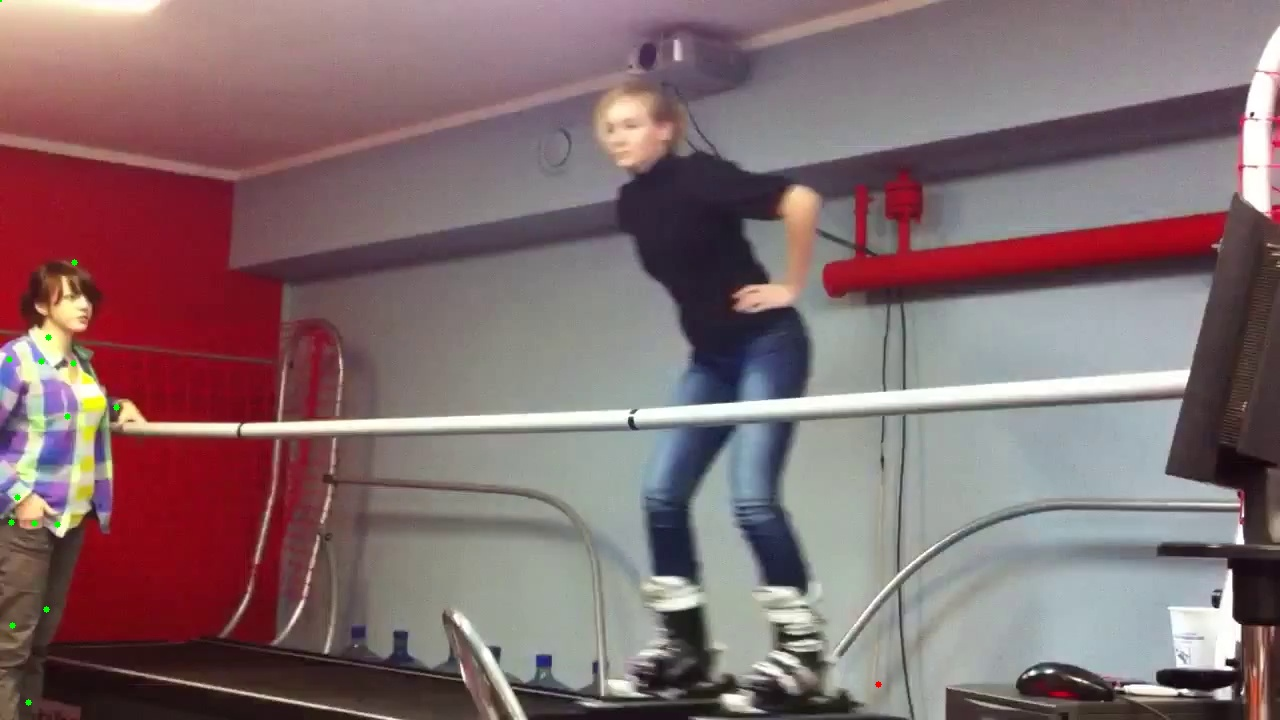

4864 014661456.jpg
torch.Size([1, 17, 2])
keypoints:  torch.Size([1, 16, 2])
[[-1176.6295   -2004.9146  ]
 [ 2029.9806    1553.6141  ]
 [ 1337.1488     479.49216 ]
 [ 1422.807      415.73047 ]
 [ 2576.7634    1926.449   ]
 [ -438.68512  -1602.2605  ]
 [ 1344.5055     487.5719  ]
 [  436.7773    -266.51065 ]
 [  437.76776   -599.1188  ]
 [   30.597214  -986.14325 ]
 [   79.91008    464.72327 ]
 [  322.60098    -47.666214]
 [  297.4477    -307.37558 ]
 [  561.4637    -227.19383 ]
 [  395.40198   -213.72371 ]
 [  413.32452    356.55463 ]]
[[ -329.6295166  -1654.91455078]
 [ 2876.98059082  1903.61413574]
 [ 2184.14880371   829.49215698]
 [ 2269.80700684   765.73046875]
 [ 3423.76342773  2276.44897461]
 [  408.31488037 -1252.26049805]
 [ 2191.50549316   837.57189941]
 [ 1283.77731323    83.48934937]
 [ 1284.76776123  -249.11877441]
 [  877.59721375  -636.14324951]
 [  926.91007996   814.7232666 ]
 [ 1169.60098267   302.33378601]
 [ 1144.44769287    42.62442017]
 [ 1408.46368408   122.806167

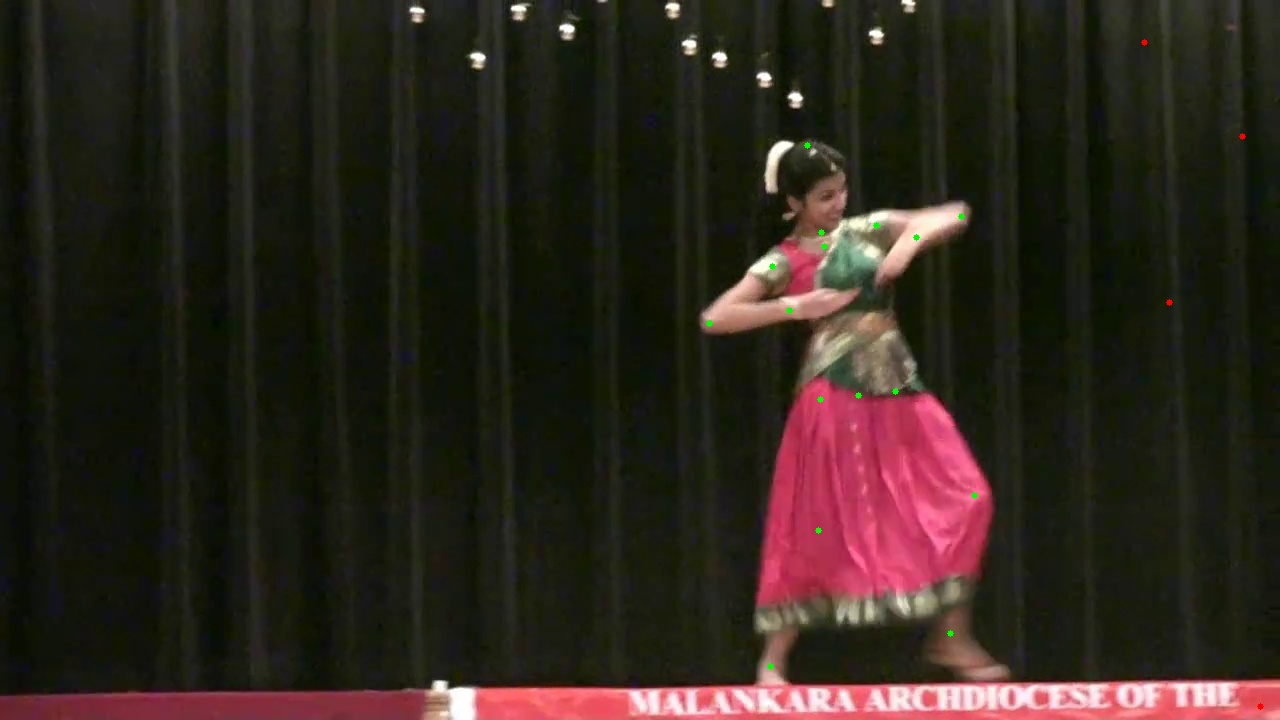

In [64]:

ROOT_FOLDER = "/datagrid/personal/baljibil"
# ground truth
with open(ROOT_FOLDER + '/data/MPII_COCO/annotations/mpii_train.json', 'r') as f:
    annot_truth = json.load(f)
# prediction
with open(ROOT_FOLDER + '/repos/scripts/data/coco_pred_mpii.json', 'r') as f:
    annot_pred_coco = json.load(f)

NUM_IMAGES = 10

# choose image from ground truth
def choose_n_images(gt_json):
  random_numbers = np.random.randint(0, len(gt_json), size=10)
  images = list()
  for nums in random_numbers:
     images.append((nums,gt_json[nums]['image']))
  return images

for index, im_path in choose_n_images(annot_truth):
  print(index, im_path)
  # Load the image
  image = cv2.imread(ROOT_FOLDER + '/data/MPII_COCO/images/' + im_path)

  # Load annotation keypoints from JSON files

  keypoints1 = annot_truth[index]['joints']
  # pred
  points = annot_pred_coco['annotations'][index]['joints']
  points = torch.tensor(points)
  points = points.unsqueeze(0)
  keypoints2 = None
  print(points.shape)
  model.eval()
  with torch.no_grad():
    points = points.to(device)
    keypoints2 = model(points)
  print('keypoints: ', keypoints2.shape)
  keypoints2 = keypoints2.squeeze()
  keypoints2 = keypoints2.to('cpu')
  keypoints2 = np.array(keypoints2)
  keypoints2 = annot_truth[index]['scale'] * keypoints2
  print(keypoints2)
  keypoints2 = keypoints2 + np.array(annot_truth[index]['center'])
  print(keypoints2)

  print(keypoints2.shape)
  # Draw keypoints on the image
  for kp in keypoints1:
      x, y = int(kp[0]), int(kp[1])
      cv2.circle(image, (x, y), 3, (0, 255, 0), -1)

  for kp in keypoints2:
      x, y = int(kp[0]), int(kp[1])
      cv2.circle(image, (x, y), 3, (0, 0, 255), -1)

  # Resize the image if necessary
  # This step is optional, depending on your images

  # Split the image horizontally
#   image1 = image[:, :image.shape[1]//2]
#   image2 = image[:, image.shape[1]//2:]

  # Display the annotated images side by side
  cv2.imwrite(f'tm_results/image{i}.jpg', image)

  display(Image(filename=f'tm_results/image{i}.jpg'))


# Try building simple regressors

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print("Train instance: ", X_train.shape[0])
print("Val instance: ", X_val.shape[0])
print("Test instance: ", X_test.shape[0])

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)


Train instance:  7861
Val instance:  2621
Test instance:  4493
torch.Size([7861, 17, 2])
torch.Size([7861, 16, 2])
torch.Size([2621, 17, 2])
torch.Size([2621, 16, 2])


In [44]:
from sklearn import linear_model

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

X_train_stacked = np.reshape(X_train, (X_train.shape[0], -1))
print(X_train_stacked.shape)
X_val_stacked = np.reshape(X_val, (X_val.shape[0], -1))
print(X_val_stacked.shape)
print('y_val: ', y_val.shape)

for point in range(16):
  y_train_point = y_train[:, point]
  clf_x = linear_model.LinearRegression()
  clf_y = linear_model.LinearRegression()

  clf_x.fit(X_train_stacked, y_train_point[:, 0])
  clf_y.fit(X_train_stacked, y_train_point[:, 1])

  prediction_x = clf_x.predict(X_val_stacked)
  prediction_y = clf_y.predict(X_val_stacked)

  pred = np.stack((prediction_x, prediction_y), axis=1)
  error = ((pred - y_val[:, point]) ** 2).mean(axis = 1)
  print(error[:10])
  error = np.mean(error)
  print(f'Error {point}: {error}')

    

(7861, 34)
(2621, 34)
y_val:  (2621, 16, 2)
[501.05557    26.484814   13.230663  370.40057   321.7471     29.803518
   4.1759033  24.76003    98.902954   17.898607 ]
Error 0: 224.21932983398438
[ 36.966908   29.610706   19.258625   38.891006  237.3109      2.9081962
  11.823391    3.8794832  96.8716      9.894313 ]
Error 1: 94.02581024169922
[4.5609488e+02 9.2181740e+00 1.6369759e+01 5.8168724e+01 2.1102634e-01
 4.3167950e+01 8.0561743e+00 6.8470888e+00 8.6960587e+01 1.5693834e+01]
Error 2: 57.048316955566406
[364.9674      4.1339636  55.83838    19.869518    7.073856   43.148983
  59.31839    74.70876    12.833171   12.851947 ]
Error 3: 58.99836730957031
[102.629906   33.302795   13.289533    7.259982    1.2742057  24.198032
   4.9489803 174.5603      2.208297   37.674953 ]
Error 4: 89.52011108398438
[7.8666875e+03 2.3242020e+01 7.0654114e+01 1.3003781e+00 4.8284893e+01
 7.0513954e+00 3.0698368e+01 7.2099037e+01 2.9583156e+00 2.6766087e+01]
Error 5: 235.37953186035156
[395.28668     5